In [74]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import plotly.graph_objects as go
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter

In [75]:

# Initialize NLTK components
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\atani\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\atani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\atani\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [100]:

# Define custom stopwords
custom_stopwords = set(stopwords.words('english')).union({
    'car', 'cars', 'fiat', 'combined', 'hyundai', 'kona', 'stellantis', 'market', 'available',
    'would', 'also', 'new', 'level', 'like', 'even', 'according', 'offered', 'move',
    'one', 'content', 'information', 'interests', 'activity', 'mean', 'go', 'quit',
    'got', 'much', 'actual', 'thing', 'bit', 'see', 'think', 'yeah', 'know', 'and', 
    'way', 'come', 'presented', 'example', 'esposito', 'lee', 'torque', 'ready', 
    'since', 'still', 'two', 'sold', 'week', 'sherpa', 'around', 'use', 'um', 
    'together', 'us', 'really', 'america', 'well', 'mirafiori', 'campaign', 'north',
    'sales', 'bag', 'says', 'get', 'world', 'germani', 'belgium', 'spain',
    'uh', 'oh', 'im', 'thats', 'youre', 'weve', 'dont', 'actually', 'ahmed', 'work', 'reuters','youve','there','going',
    'gelateria', 'list', 'required', 'instead', 'added', 'inbox', 'honda', 'help', 'dedicated',
    'inform', 'news', 'group', 'report', 'couldnt', 'three', 'including', 'however', 'people','ev', 'review', 'avenger','wave','electric','mini','bmw',
    'want','cant','though','chinese'
})
custom_stopwords = list(custom_stopwords)  # Convert the set to a list

# Function to preprocess the text
def preprocess(text):
    if pd.isna(text):
        return ''  # Handle NaN values
    text = text.lower()  # Convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in custom_stopwords and word.isalpha()]  # Remove stopwords
    return ' '.join(tokens)

In [101]:
# Function to find the optimal number of clusters
def find_optimal_clusters(X, max_k=10):
    inertia = []
    silhouette = []
    
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
        try:
            silhouette.append(silhouette_score(X, kmeans.labels_))
        except:
            silhouette.append(-1)
    
    # Determine the optimal number of clusters
    optimal_k = silhouette.index(max(silhouette)) + 2  # Adding 2 because range starts at 2

    # Plot Elbow Method
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_k + 1), inertia, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    
    # Plot Silhouette Score
    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_k + 1), silhouette, marker='o')
    plt.title('Silhouette Score')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    
    plt.tight_layout()
    plt.show()

    return optimal_k

In [102]:
# Function to perform clustering, get top comments, and calculate sentiment scores
def perform_clustering_and_get_top_comments(data, car_name, max_k=10):
    car_data = data[data['Car'] == car_name]
    
    # Preprocess the text
    car_data['Processed_Text'] = car_data['Text'].apply(preprocess)
    
    # Check if there are any non-empty documents
    if car_data['Processed_Text'].str.strip().eq('').all():
        raise ValueError(f'No valid text data for {car_name}. All documents may be empty or contain only stop words.')
    
    # Vectorize the text data using TF-IDF
    vectorizer = TfidfVectorizer(max_features=1000)
    X = vectorizer.fit_transform(car_data['Processed_Text'])
    
    # Check if the TF-IDF matrix is empty
    if X.shape[0] == 0:
        raise ValueError(f'Empty TF-IDF matrix for {car_name}. This might be due to empty or stopword-filtered documents.')

    # Find the optimal number of clusters
    optimal_k = find_optimal_clusters(X, max_k)
    print(f'Optimal number of clusters for {car_name}: {optimal_k}')
    
    # Perform clustering with optimal number of clusters
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    car_data['Cluster'] = kmeans.fit_predict(X)
    
    # Initialize VADER sentiment analyzer
    sia = SentimentIntensityAnalyzer()
    
    # Get top comments and sentiment scores for each cluster
    top_comments = {}
    sentiment_scores = {}
    for cluster in range(optimal_k):
        cluster_comments = car_data[car_data['Cluster'] == cluster]['Text'].tolist()
        top_comments[cluster] = cluster_comments[:5]  # Get top 5 comments

        # Calculate sentiment scores
        sentiment = [sia.polarity_scores(comment)['compound'] for comment in cluster_comments]
        avg_sentiment = sum(sentiment) / len(sentiment) if sentiment else 0
        sentiment_scores[cluster] = avg_sentiment
    
    return car_data, top_comments, sentiment_scores

In [103]:
# Load the dataset
competitors_data = pd.read_csv(r'C:\Users\atani\OneDrive - City, University of London\Tanisha\ARP\competitor_comments_combined_cleaned (1).csv')

# Ensure all values in the 'Text' column are strings and handle missing values
competitors_data['Text'] = competitors_data['Text'].astype(str).fillna('')

# List of car names in your dataset
car_names = competitors_data['Car'].unique()


Processing Jeep Avenger...


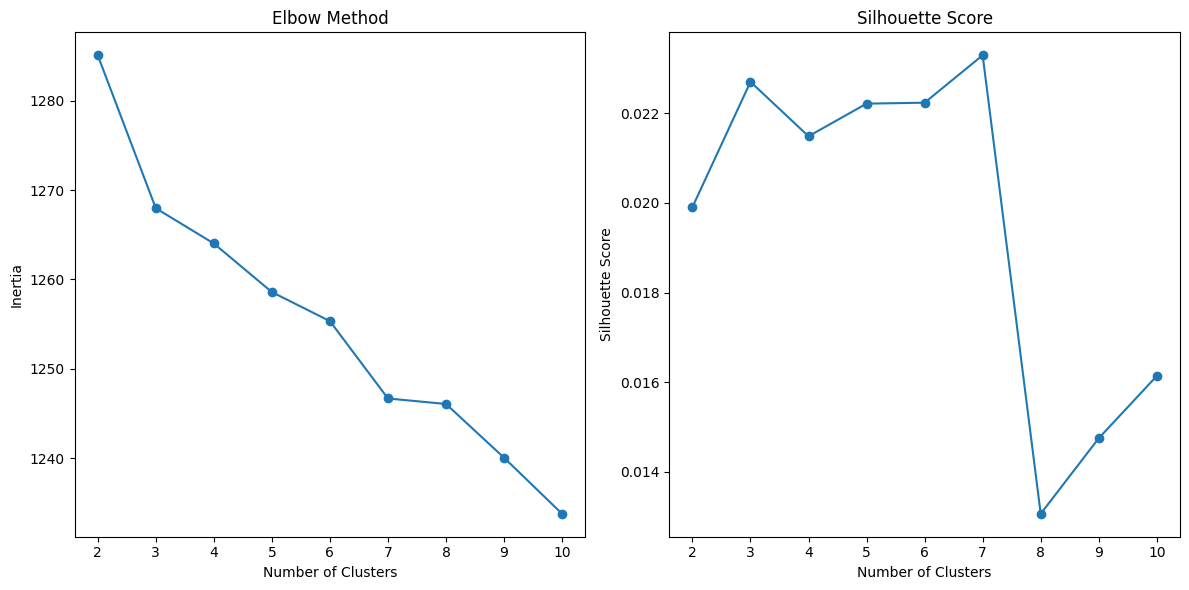

Optimal number of clusters for Jeep Avenger: 7
Processing Hyundai Kona...


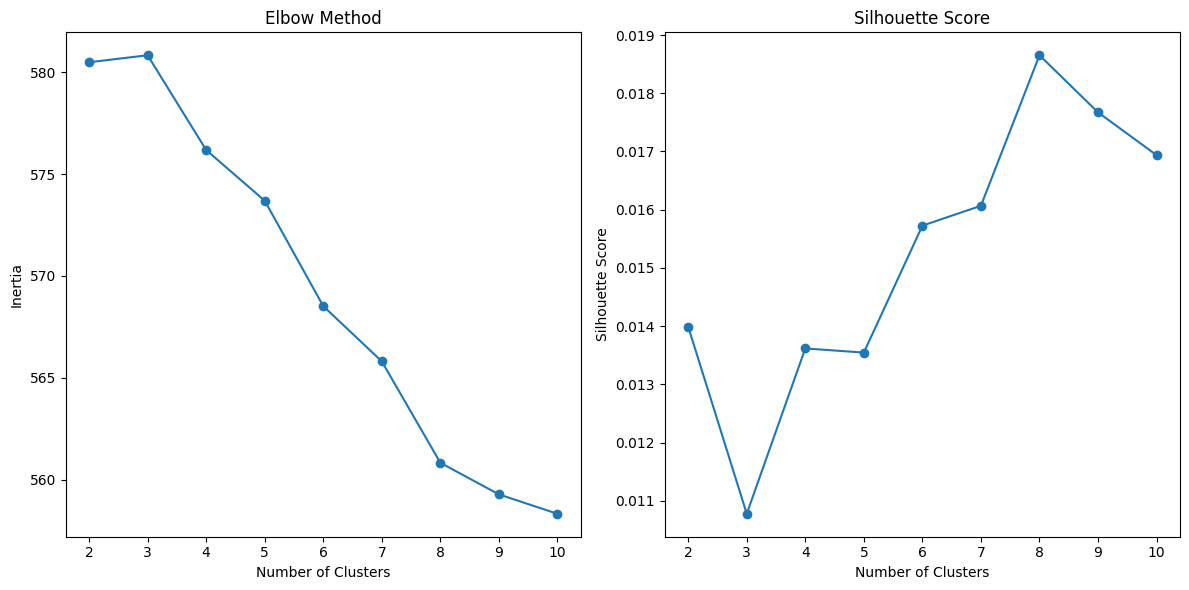

Optimal number of clusters for Hyundai Kona: 8
Processing Peugeot e2008...


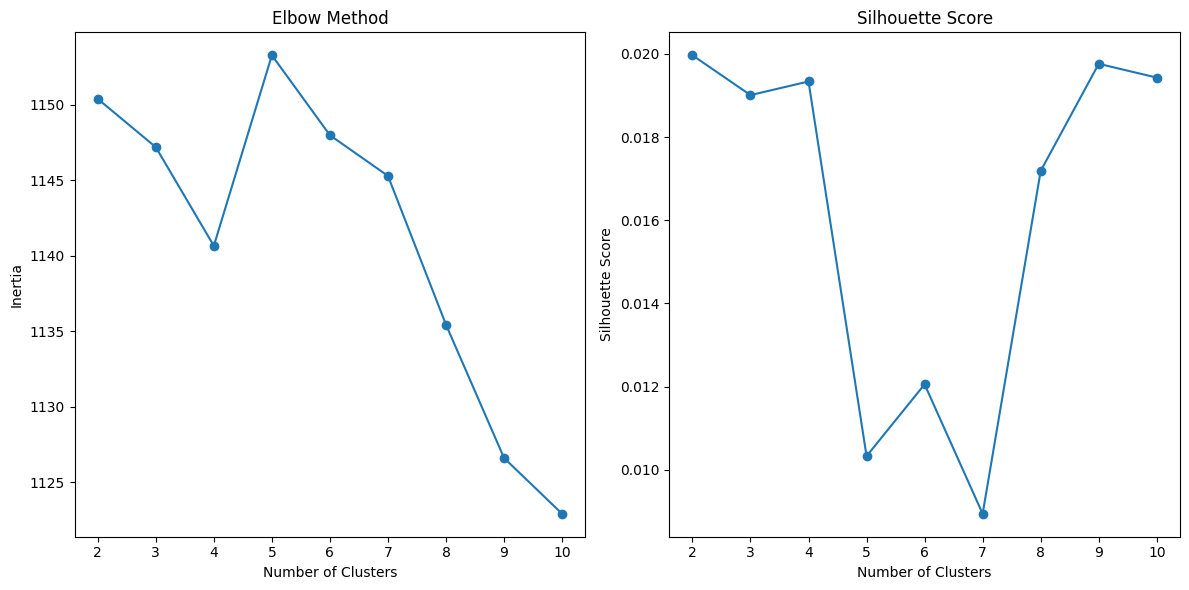

Optimal number of clusters for Peugeot e2008: 2
Processing Vauxhall Mokka...


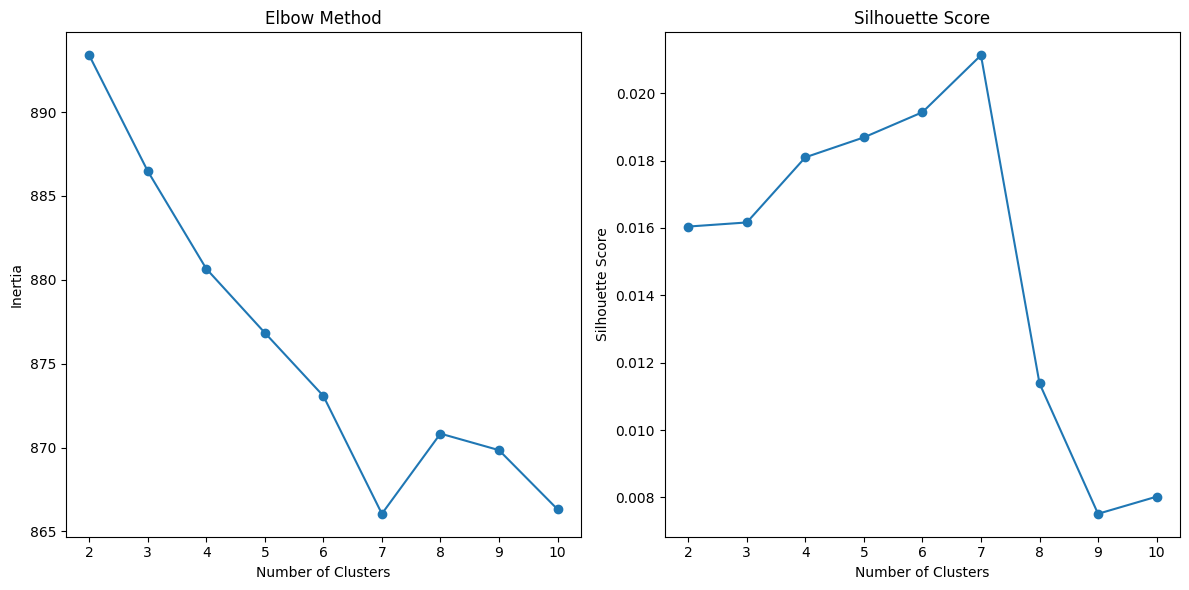

Optimal number of clusters for Vauxhall Mokka: 7
Processing Mini Cooper...


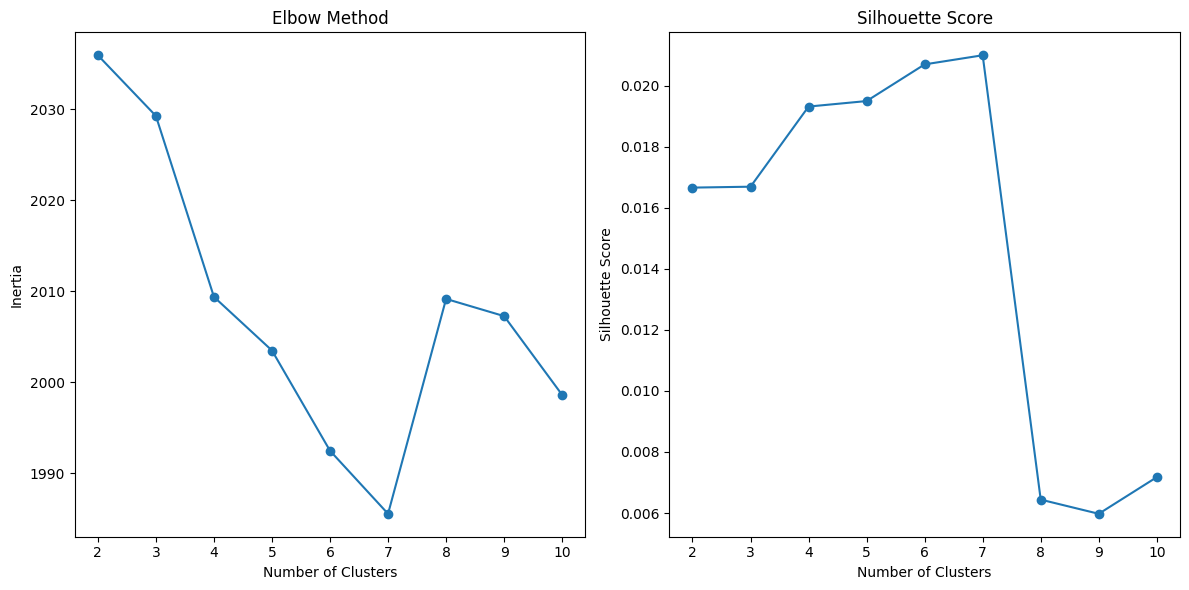

Optimal number of clusters for Mini Cooper: 7
Car: Jeep Avenger
Top comments for each cluster and their sentiment scores:
Cluster 0:
 - 96s for that price tag is slow same price on an ice car would be much better than that
 - im a fan of this car but the price is ridiculous for a small car with 4 year old electric car tech its going to get destroyed by the volvo ex30 and the fisker pear when they arrive both will be the same money but years ahead in terms of tech and design its a pity stellantis couldve done a dacia and sold off the old tech at a knock down price personally i dont get what the premium price gets you better residuals
 - i think it won because its a likeable car theres nothing inoffensive about it its practical and well designed impractical flawed or expensive cars win car of the year all of the time sometimes really dull stuff wins i think this is a decent all rounder though the price is pretty steep the ex30 and the fisker pear will blow this out of the water though it

In [104]:
# Filter out NaN car names
car_names = [name for name in car_names if pd.notna(name)]

# Perform clustering for each car and get top comments and sentiment scores
results = {}
for car_name in car_names:
    print(f'Processing {car_name}...')
    try:
        clustered_data, top_comments, sentiment_scores = perform_clustering_and_get_top_comments(competitors_data, car_name)
        results[car_name] = {
            'Clustered_Data': clustered_data,
            'Top_Comments': top_comments,
            'Sentiment_Scores': sentiment_scores
        }
    except ValueError as e:
        print(e)

# Access results
for car_name, result in results.items():
    print(f'Car: {car_name}')
    print('Top comments for each cluster and their sentiment scores:')
    for cluster, comments in result['Top_Comments'].items():
        print(f'Cluster {cluster}:')
        for comment in comments:
            print(f' - {comment}')
        print(f'Sentiment Score: {result["Sentiment_Scores"][cluster]}')




# Clustering analysis on the combined dataset of all the 5 competitors 

Optimal number of clusters (Elbow Method): 4
Optimal number of clusters (Silhouette Method): 5


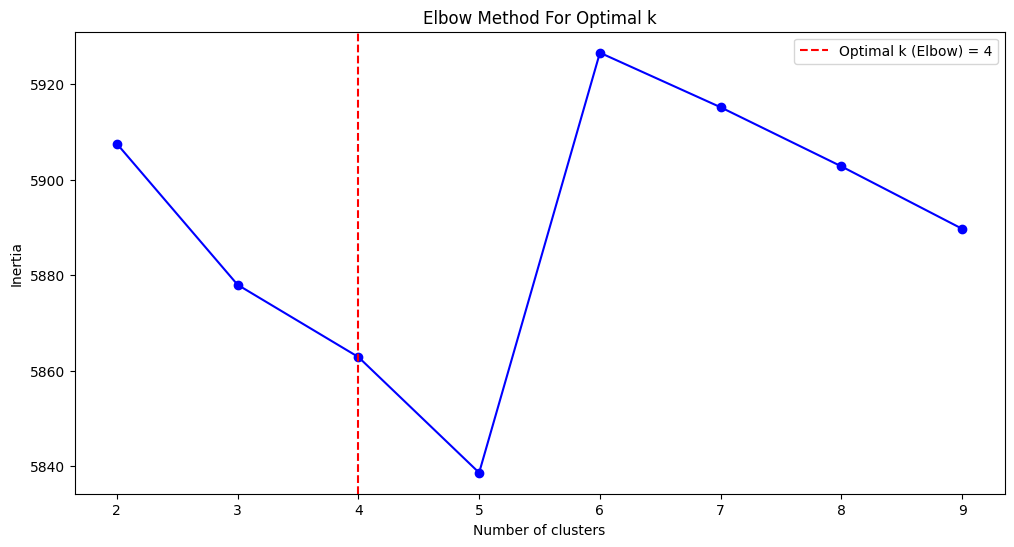

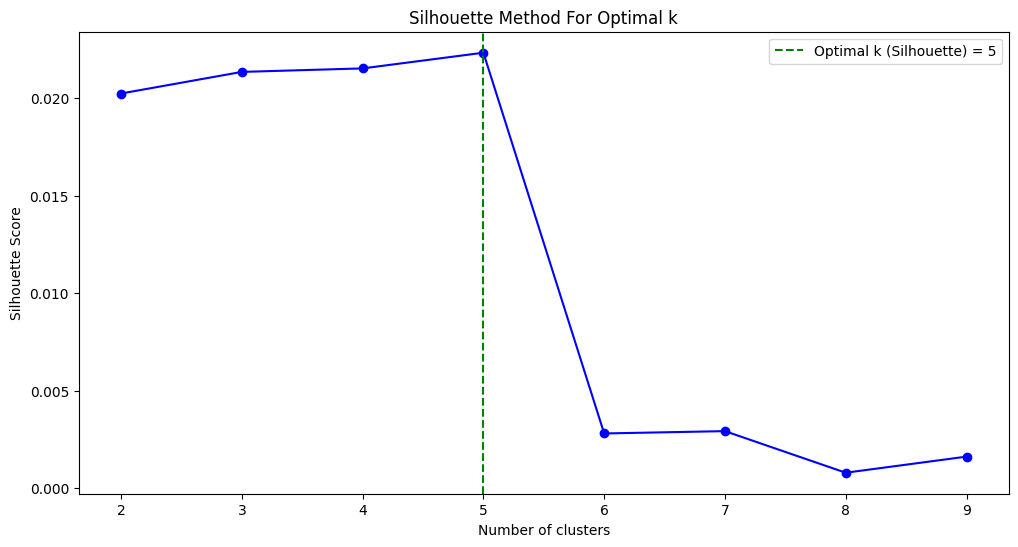

In [81]:
# Apply preprocessing to the text column
competitors_data['Processed_Text'] = competitors_data['Text'].apply(preprocess)

# Create a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words=custom_stopwords)
X_tfidf = tfidf_vectorizer.fit_transform(competitors_data['Processed_Text'])

# Apply the Elbow Method to determine the optimal number of clusters
inertia = []
silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_tfidf, kmeans.labels_))

# Determine optimal k using both methods
def find_optimal_k(inertia, silhouette_scores, K_range):
    optimal_k_elbow = np.argmax(np.diff(np.diff(inertia))) + 2
    optimal_k_silhouette = np.argmax(silhouette_scores) + 2
    return optimal_k_elbow, optimal_k_silhouette

optimal_k_elbow, optimal_k_silhouette = find_optimal_k(inertia, silhouette_scores, K_range)

print(f"Optimal number of clusters (Elbow Method): {optimal_k_elbow}")
print(f"Optimal number of clusters (Silhouette Method): {optimal_k_silhouette}")

# Plotting the inertia to find the elbow with optimal k line
plt.figure(figsize=(12, 6))
plt.plot(K_range, inertia, 'bo-')
plt.axvline(x=optimal_k_elbow, color='red', linestyle='--', label=f'Optimal k (Elbow) = {optimal_k_elbow}')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.legend()
plt.show()

# Plotting the silhouette scores with optimal k line
plt.figure(figsize=(12, 6))
plt.plot(K_range, silhouette_scores, 'bo-')
plt.axvline(x=optimal_k_silhouette, color='green', linestyle='--', label=f'Optimal k (Silhouette) = {optimal_k_silhouette}')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.legend()
plt.show()

In [82]:
# Perform clustering with the optimal number of clusters (choose one method's optimal k)
num_clusters = optimal_k_silhouette

# Detailed K- Mean Clustering

In [83]:
# Perform K-means clustering
kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)
competitors_data['Cluster'] = kmeans_model.fit_predict(X_tfidf)

# Analyze the clusters
def analyze_clusters(kmeans_model, X_tfidf, tfidf_vectorizer, num_clusters):
    # Top terms per cluster
    order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1]
    terms = tfidf_vectorizer.get_feature_names_out()
    
    print("Top terms per cluster:")
    for i in range(num_clusters):
        print(f"Cluster {i}: ", end='')
        print(', '.join([terms[ind] for ind in order_centroids[i, :10]]))

    # Cluster sizes
    cluster_sizes = competitors_data['Cluster'].value_counts()
    print("\nCluster sizes:")
    print(cluster_sizes)
    
    return cluster_sizes


# Function to extract and display comments for each cluster
def extract_comments_per_cluster(competitors_data, num_clusters):
    cluster_comments = {}
    
    for i in range(num_clusters):
        # Filter the DataFrame to get comments in the current cluster
        cluster_data = competitors_data[competitors_data['Cluster'] == i]['Text']
        cluster_comments[i] = cluster_data.tolist()  # Convert the comments to a list
        
        # Display the cluster and the first few comments
        print(f"\nCluster {i} - {len(cluster_comments[i])} Comments:")
        for comment in cluster_comments[i][:10]:  # Display the first 5 comments for each cluster
            print(f" - {comment}")
    
    return cluster_comments

# Apply the function to your dataset
cluster_comments = extract_comments_per_cluster(competitors_data, num_clusters)

cluster_sizes = analyze_clusters(kmeans_model, X_tfidf, tfidf_vectorizer, num_clusters)



Cluster 0 - 580 Comments:
 - msjranger no problems with it so far great little car range is around 220 summer 160170 winter motorway driving at 70mph youll get 170miles
 - kalelgreece no problems with it so far great little car range is around 220 summer 160170 winter motorway driving at 70mph youll get 170miles
 - they have done an excellent job with the avenger great blend of price design and function  not an easy trick to pull off and i can see this being a very appealing car to a wide range of buyers interesting section about the cool model names as well i have a theory its actually the jeep part that makes them cool though  hillman avenger  sadness and disappointment jeep avenger  coolness and desirability see o
 - why quote the wltp range as a good thing when we all know its a lie
 - 96s for that price tag is slow same price on an ice car would be much better than that
 - im a fan of this car but the price is ridiculous for a small car with 4 year old electric car tech its going

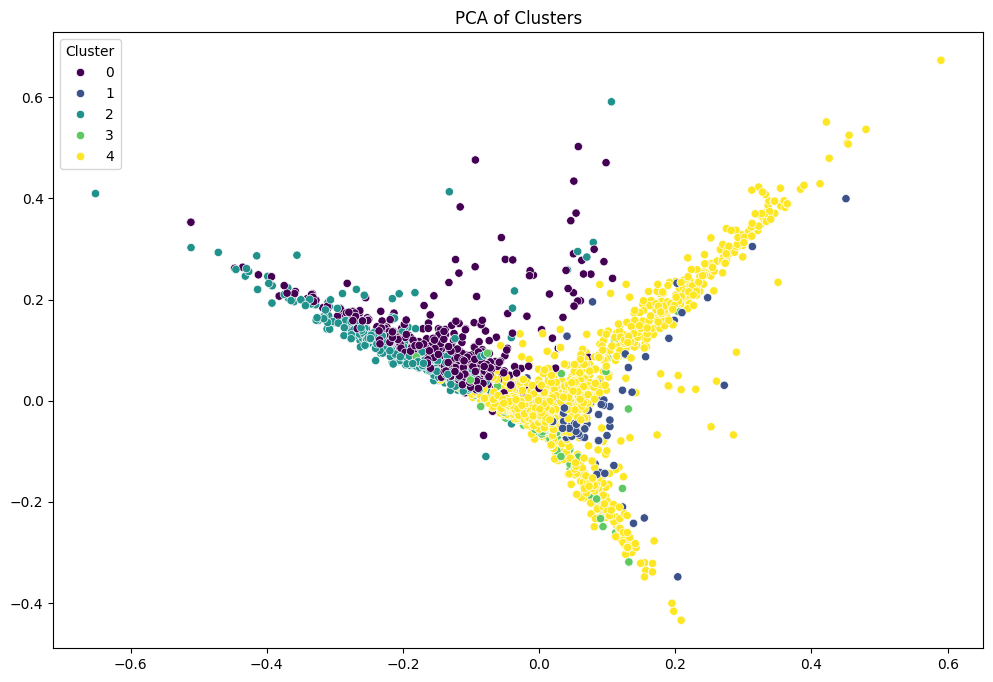

In [84]:
# Visualize clusters using PCA
def plot_pca(X_tfidf, competitors_data):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_tfidf.toarray())
    
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=competitors_data['Cluster'], palette="viridis", legend="full")
    plt.title('PCA of Clusters')
    plt.show()

plot_pca(X_tfidf, competitors_data)


In [85]:

# Initialize VADER Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment_scores(text):
    sentiment = sia.polarity_scores(text)
    blob = TextBlob(text)
    return sentiment['compound'], blob.sentiment.subjectivity

# Apply sentiment analysis to the processed text
competitors_data['Sentiment_Score'], competitors_data['Subjectivity'] = zip(*competitors_data['Processed_Text'].apply(get_sentiment_scores))

# Analyze average sentiment scores per cluster
def analyze_sentiment_per_cluster(competitors_data):
    sentiment_per_cluster = competitors_data.groupby('Cluster').agg({
        'Sentiment_Score': ['mean', 'std'],
        'Subjectivity': ['mean', 'std']
    })
    return sentiment_per_cluster

# Calculate and print average sentiment scores for each cluster
average_sentiment_per_cluster = analyze_sentiment_per_cluster(competitors_data)
print("Average Sentiment and Subjectivity Scores per Cluster:")
print(average_sentiment_per_cluster)

Average Sentiment and Subjectivity Scores per Cluster:
        Sentiment_Score           Subjectivity          
                   mean       std         mean       std
Cluster                                                 
0              0.181275  0.495185     0.488908  0.264251
1              0.660392  0.277658     0.588183  0.118611
2              0.139291  0.449487     0.420252  0.266616
3              0.334429  0.439820     0.376277  0.259034
4              0.121454  0.423610     0.392935  0.332091


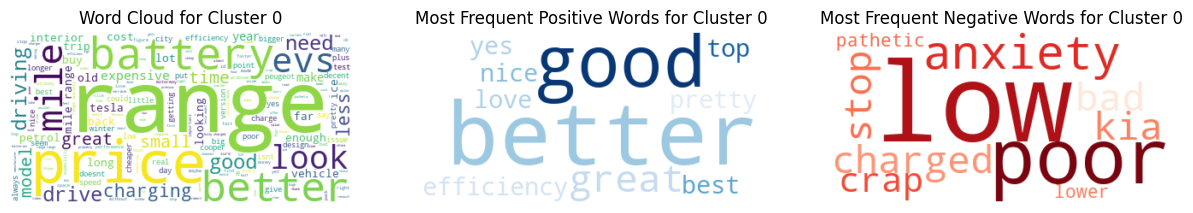

Most Frequent Positive Words for Cluster 0:
better: 96 times
good: 67 times
great: 48 times
efficiency: 26 times
yes: 22 times
nice: 21 times
best: 21 times
pretty: 19 times
top: 18 times
love: 18 times

--------------------------------------------------

Most Frequent Negative Words for Cluster 0:
low: 20 times
poor: 20 times
anxiety: 19 times
charged: 18 times
bad: 16 times
kia: 16 times
stop: 13 times
crap: 12 times
pathetic: 12 times
lower: 11 times




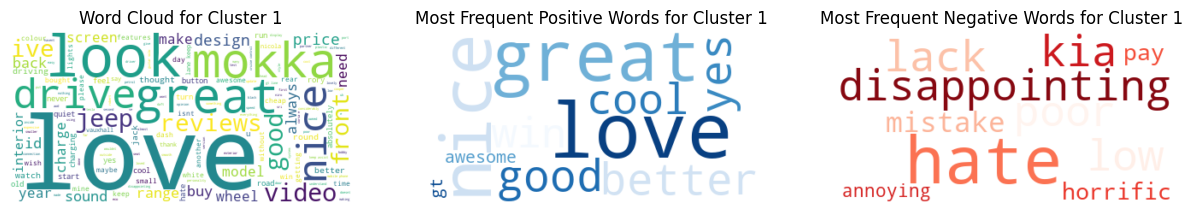

Most Frequent Positive Words for Cluster 1:
love: 195 times
great: 18 times
nice: 13 times
good: 11 times
better: 6 times
yes: 5 times
cool: 5 times
win: 4 times
awesome: 4 times
gt: 4 times

--------------------------------------------------

Most Frequent Negative Words for Cluster 1:
hate: 4 times
disappointing: 3 times
poor: 3 times
low: 3 times
lack: 2 times
kia: 2 times
mistake: 2 times
horrific: 2 times
pay: 2 times
annoying: 2 times




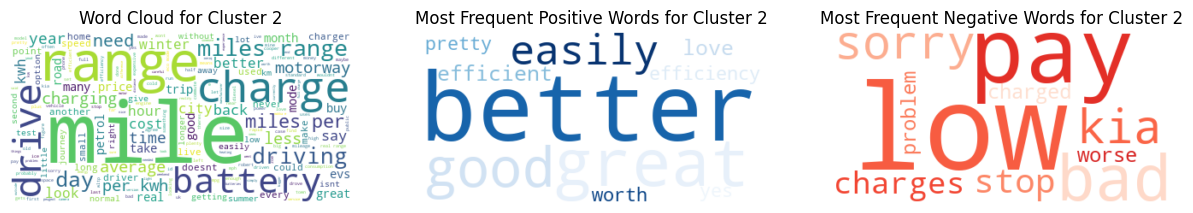

Most Frequent Positive Words for Cluster 2:
better: 26 times
great: 25 times
good: 23 times
easily: 16 times
efficient: 12 times
love: 10 times
efficiency: 9 times
yes: 9 times
pretty: 8 times
worth: 7 times

--------------------------------------------------

Most Frequent Negative Words for Cluster 2:
low: 14 times
pay: 12 times
bad: 12 times
sorry: 10 times
kia: 9 times
stop: 9 times
charges: 8 times
charged: 8 times
problem: 8 times
worse: 7 times




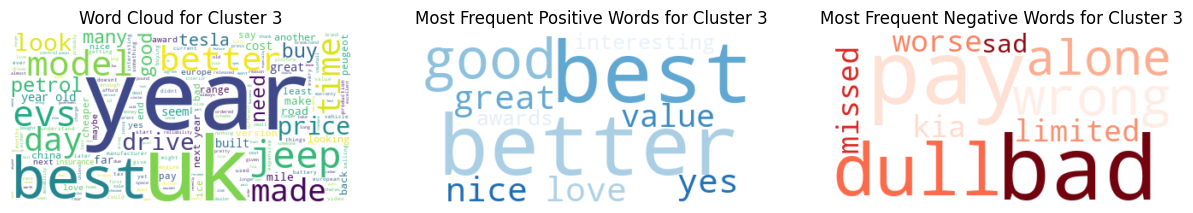

Most Frequent Positive Words for Cluster 3:
best: 85 times
better: 23 times
good: 15 times
great: 14 times
nice: 9 times
love: 9 times
yes: 9 times
value: 7 times
interesting: 7 times
awards: 6 times

--------------------------------------------------

Most Frequent Negative Words for Cluster 3:
bad: 10 times
pay: 10 times
dull: 4 times
wrong: 4 times
alone: 3 times
limited: 3 times
missed: 3 times
worse: 3 times
kia: 3 times
sad: 2 times




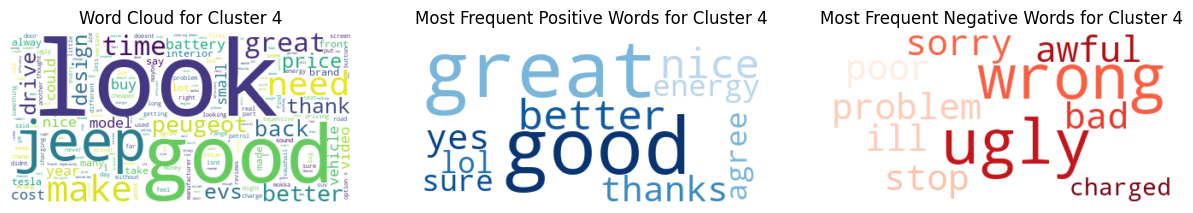

Most Frequent Positive Words for Cluster 4:
good: 321 times
great: 254 times
better: 223 times
nice: 151 times
thanks: 133 times
yes: 96 times
energy: 94 times
sure: 90 times
agree: 78 times
lol: 74 times

--------------------------------------------------

Most Frequent Negative Words for Cluster 4:
ugly: 92 times
wrong: 81 times
problem: 72 times
stop: 60 times
bad: 60 times
awful: 51 times
ill: 47 times
sorry: 46 times
poor: 45 times
charged: 41 times




In [86]:
# Function to generate word clouds and print the most frequent positive and negative words
def generate_sentiment_wordclouds(competitors_data, num_clusters, top_n=10):
    # Dictionaries to store the most frequent positive and negative words for each cluster
    frequent_positive_words_dict = {}
    frequent_negative_words_dict = {}

    for i in range(num_clusters):
        cluster_text = competitors_data[competitors_data['Cluster'] == i]['Processed_Text']
        text = ' '.join(cluster_text)
        
        # Generate word cloud
        wordcloud = WordCloud(stopwords=custom_stopwords, background_color='white').generate(text)
        
        # Generate positive word cloud and count positive words
        positive_words = [word for word in text.split() if sia.polarity_scores(word)['compound'] > 0]
        positive_word_freq = Counter(positive_words)
        most_common_positive_words = positive_word_freq.most_common(top_n)
        positive_text = ' '.join([word for word, _ in most_common_positive_words])
        positive_wordcloud = WordCloud(stopwords=custom_stopwords, background_color='white', colormap='Blues').generate(positive_text)
        
        # Generate negative word cloud and count negative words
        negative_words = [word for word in text.split() if sia.polarity_scores(word)['compound'] < 0]
        negative_word_freq = Counter(negative_words)
        most_common_negative_words = negative_word_freq.most_common(top_n)
        negative_text = ' '.join([word for word, _ in most_common_negative_words])
        negative_wordcloud = WordCloud(stopwords=custom_stopwords, background_color='white', colormap='Reds').generate(negative_text)
        
        # Store the most frequent positive and negative words in their respective dictionaries
        frequent_positive_words_dict[i] = most_common_positive_words
        frequent_negative_words_dict[i] = most_common_negative_words
        
        # Plotting the word clouds
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f'Word Cloud for Cluster {i}')
        
        plt.subplot(1, 3, 2)
        plt.imshow(positive_wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f'Most Frequent Positive Words for Cluster {i}')
        
        plt.subplot(1, 3, 3)
        plt.imshow(negative_wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f'Most Frequent Negative Words for Cluster {i}')
        
        plt.show()

        # Print the most frequent positive words
        print(f"Most Frequent Positive Words for Cluster {i}:")
        for word, freq in most_common_positive_words:
            print(f'{word}: {freq} times')
        print("\n" + "-"*50 + "\n")

        # Print the most frequent negative words
        print(f"Most Frequent Negative Words for Cluster {i}:")
        for word, freq in most_common_negative_words:
            print(f'{word}: {freq} times')
        print("\n" + "="*50 + "\n")

# Generate word clouds and print the most frequent positive and negative words
generate_sentiment_wordclouds(competitors_data, num_clusters, top_n=10)